### SVM Model with PCA

In [1]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load data
df_train = pd.read_parquet('train_df.parquet', engine='pyarrow')
df_test = pd.read_parquet('test_df.parquet', engine='pyarrow')

X_train = df_train.drop(
    ["is_anomalous", "_ANOMALY_TYPES_DROP_BEFORE_TRAINING_"], axis=1, errors="ignore"
)
y_train = df_train["is_anomalous"]
X_test = df_test.drop(
    ["is_anomalous", "_ANOMALY_TYPES_DROP_BEFORE_TRAINING_"], axis=1, errors="ignore"
)
y_test = df_test["is_anomalous"]
# Identify categorical columns and label-encode them
col_types = dict(X_train.dtypes)
label_cols = [col for col, dtype in col_types.items() if dtype == 'object']

encoders = {}
for col in label_cols:
    encoder = LabelEncoder()
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    encoder.fit(combined)
    X_train[col] = encoder.transform(X_train[col].astype(str))
    X_test[col] = encoder.transform(X_test[col].astype(str))
    encoders[col] = encoder

# drop date columns
X_train = X_train.drop(columns=['invoice_date', 'due_date'])
X_test = X_test.drop(columns=['invoice_date', 'due_date'])

# standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# dimensionality reduction
pca = PCA(n_components=10, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train an SVM with RBF Kernel on the PCA features
model = SVC(kernel='rbf',
            C=1.0,
            gamma='scale',
            class_weight='balanced',
            probability=True,
            random_state=42)

model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9407020872865275

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      1198
           1       0.99      0.87      0.93       910

    accuracy                           0.94      2108
   macro avg       0.95      0.93      0.94      2108
weighted avg       0.95      0.94      0.94      2108



### without merchant info

In [2]:
X_train = X_train.drop(columns=['merchant', 'merchant_branch', 'merchant_chain', 'merchant_address'])
X_test = X_test.drop(columns=['merchant', 'merchant_branch', 'merchant_chain', 'merchant_address'])

# Identify categorical columns
col_types = dict(X_train.dtypes)
label_cols = [col for col, dtype in col_types.items() if dtype == 'object']

# Label encode each categorical column (keeping consistency between train and test)
encoders = {}
for col in label_cols:
    encoder = LabelEncoder()
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    encoder.fit(combined)
    X_train[col] = encoder.transform(X_train[col].astype(str))
    X_test[col] = encoder.transform(X_test[col].astype(str))
    encoders[col] = encoder  # Optional: store encoders for inverse_transform or future use
    
# standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# dimensionality reduction
pca = PCA(n_components=10, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train an SVM with RBF Kernel on the PCA features
model = SVC(kernel='rbf',
            C=1.0,
            gamma='scale',
            class_weight='balanced',
            probability=True,
            random_state=42)

model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.948292220113852

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      1198
           1       1.00      0.88      0.94       910

    accuracy                           0.95      2108
   macro avg       0.96      0.94      0.95      2108
weighted avg       0.95      0.95      0.95      2108



### Threshold adjustment for better recall results

In [3]:
y_proba = model.predict_proba(X_test_pca)[:, 1]
y_pred_thresh = (y_proba >= 0.3).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred_thresh))

Accuracy: 0.948292220113852
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1198
           1       0.94      0.90      0.92       910

    accuracy                           0.93      2108
   macro avg       0.93      0.93      0.93      2108
weighted avg       0.93      0.93      0.93      2108



### Adding feature importance graph

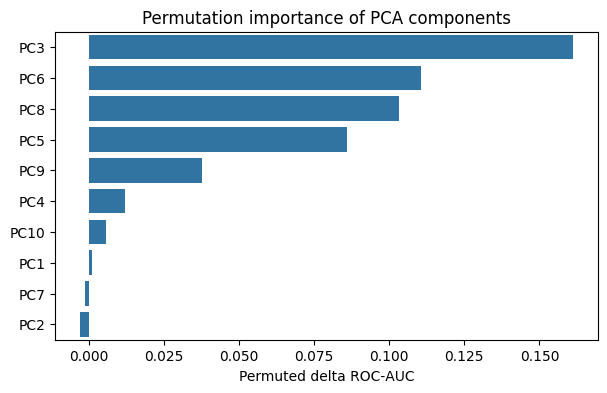

In [4]:
# use permutation importance for non-linear SVM
perm = permutation_importance(
    model,                 
    X_test_pca,             
    y_test,
    n_repeats=30,
    scoring="roc_auc",
    random_state=42,
)

pca_imp = (
    pd.DataFrame(
        {"component": [f"PC{i+1}" for i in range(pca.n_components_)],
         "importance": perm.importances_mean}
    )
    .sort_values("importance", ascending=False)
)

plt.figure(figsize=(7, 4))
sns.barplot(data=pca_imp, x="importance", y="component", orient="h")
plt.title("Permutation importance of PCA components")
plt.xlabel("Permuted delta ROC‑AUC")
plt.ylabel("")
plt.show()

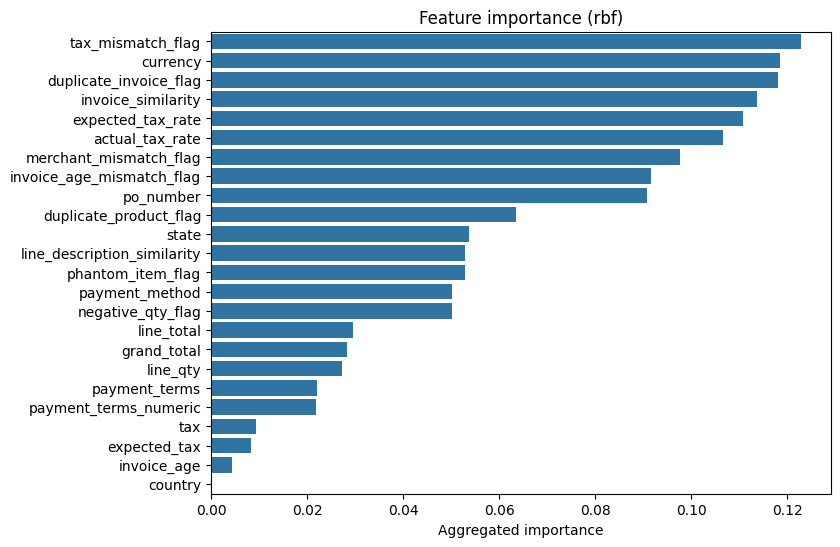

In [ ]:
# Map component importance back to raw features
loadings = np.abs(pca.components_)        # (k × p)
comp_weights = pca_imp.set_index("component").loc[
    [f"PC{i+1}" for i in range(pca.n_components_)]
]["importance"].values                    # (k,)

# calculate raw scores
raw_scores = loadings.T @ comp_weights    # (p,)

feat_imp = (
    pd.DataFrame({"feature": X_train.columns, "importance": raw_scores})
    .sort_values("importance", ascending=False)
)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=feat_imp, 
    x="importance",
    y="feature",
    orient="h"
)
plt.title("Feature importance (rbf)")
plt.xlabel("Aggregated importance")
plt.ylabel("")
plt.show()

In [6]:
# Hyperparameters tuning using grid search

# import pandas as pd
# from sklearn.preprocessing import LabelEncoder
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, classification_report

# df_train = pd.read_parquet('train_df.parquet', engine='pyarrow')
# df_test = pd.read_parquet('test_df.parquet', engine='pyarrow')

# X_train = df_train.drop('is_anomalous', axis=1)
# y_train = df_train['is_anomalous']
# X_test = df_test.drop('is_anomalous', axis=1)
# y_test = df_test['is_anomalous']

# # Label Encode Categorical Columns
# col_types = dict(X_train.dtypes)
# label_cols = [col for col, dtype in col_types.items() if dtype == 'object']

# encoders = {}
# for col in label_cols:
#     encoder = LabelEncoder()
#     # Combine train & test for consistent mapping
#     combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
#     encoder.fit(combined)
#     X_train[col] = encoder.transform(X_train[col].astype(str))
#     X_test[col] = encoder.transform(X_test[col].astype(str))
#     encoders[col] = encoder

# X_train['time_until_due'] = (X_train['due_date'] - X_train['invoice_date']).dt.days
# X_test['time_until_due'] = (X_test['due_date'] - X_test['invoice_date']).dt.days
# # Drop the raw datetime columns (no longer needed)
# X_train.drop(columns=['invoice_date', 'due_date'], inplace=True)
# X_test.drop(columns=['invoice_date', 'due_date'], inplace=True)

# # Use grid search for best kernel SVM
# param_grid = {
#     'kernel': ['linear', 'poly', 'rbf'],
#     'C': [1.0],
#     'gamma': ['scale'],
#     'class_weight': ['balanced']  
# }

# svm = SVC(random_state=42)
# grid_search = GridSearchCV(
#     estimator=svm,
#     param_grid=param_grid,
#     scoring='recall',    
#     cv=3,                
#     verbose=1,
#     n_jobs=-1    
# )

# print("Searching for the best SVM configuration...")
# grid_search.fit(X_train, y_train)

# # Retrieve the best model
# best_svm = grid_search.best_estimator_
# print(f"Best Parameters: {grid_search.best_params_}")

# # Final Model Evaluation
# y_pred = best_svm.predict(X_test)

# # accuracy
# print("\nAccuracy on Test Set:", accuracy_score(y_test, y_pred))
# print("\nClassification Report on Test Set:\n", classification_report(y_test, y_pred))